In [152]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [153]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, make_scorer
import time

In [154]:
os.chdir(r'C:\Users\saura\OneDrive\Documents\IIT Hyderabad\Assignments\ML\Assignment_3')

In [155]:
os.listdir()

['Answers', 'loan_test.csv', 'loan_train.csv', 'Self Study', 'spam.data.txt']

### Loading the data

In [156]:

loan_train = pd.read_csv('loan_train.csv')

In [157]:
loan_test = pd.read_csv('loan_test.csv')

In [158]:
loan_test.shape

(14718, 111)

# Pre processing starts

### Setting the target class

In [159]:
loan_train.loan_status.value_counts()

Fully Paid     20827
Charged Off     3474
Current          698
Name: loan_status, dtype: int64

In [160]:
loan_test.loan_status.value_counts()

Fully Paid     12123
Charged Off     2153
Current          442
Name: loan_status, dtype: int64

In [161]:
loan_train = loan_train[loan_train.loan_status!= 'Current']
loan_train['target'] = np.where(loan_train.loan_status == 'Fully Paid',1,0)
loan_train.drop(['loan_status'],axis =1,inplace = True)
loan_train.target.value_counts()

1    20827
0     3474
Name: target, dtype: int64

## Dropping columns with High Missing Values

In [162]:
dict_loan = loan_train.isna().sum().to_dict()
dict_loan = {key: value for (key, value) in dict_loan.items() if value!=0 }
dict_loan

{'emp_title': 6,
 'emp_length': 40,
 'desc': 7943,
 'title': 8,
 'mths_since_last_delinq': 15767,
 'mths_since_last_record': 22646,
 'revol_util': 29,
 'last_pymnt_d': 45,
 'next_pymnt_d': 24301,
 'collections_12_mths_ex_med': 29,
 'mths_since_last_major_derog': 24301,
 'annual_inc_joint': 24301,
 'dti_joint': 24301,
 'verification_status_joint': 24301,
 'tot_coll_amt': 24301,
 'tot_cur_bal': 24301,
 'open_acc_6m': 24301,
 'open_il_6m': 24301,
 'open_il_12m': 24301,
 'open_il_24m': 24301,
 'mths_since_rcnt_il': 24301,
 'total_bal_il': 24301,
 'il_util': 24301,
 'open_rv_12m': 24301,
 'open_rv_24m': 24301,
 'max_bal_bc': 24301,
 'all_util': 24301,
 'total_rev_hi_lim': 24301,
 'inq_fi': 24301,
 'total_cu_tl': 24301,
 'inq_last_12m': 24301,
 'acc_open_past_24mths': 24301,
 'avg_cur_bal': 24301,
 'bc_open_to_buy': 24301,
 'bc_util': 24301,
 'chargeoff_within_12_mths': 29,
 'mo_sin_old_il_acct': 24301,
 'mo_sin_old_rev_tl_op': 24301,
 'mo_sin_rcnt_rev_tl_op': 24301,
 'mo_sin_rcnt_tl': 24301

### remove any columns with more than 60% null values

In [163]:
not_null_cols = loan_train.columns[loan_train.isnull().mean() < 0.6]
print('no of columns remaining after removing any columns with more than 60% null values : ',len(not_null_cols))# 
loan_train= loan_train.filter(not_null_cols,axis = 1)
loan_train.isna().sum()

no of columns remaining after removing any columns with more than 60% null values :  54


id                               0
member_id                        0
loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
term                             0
int_rate                         0
installment                      0
grade                            0
sub_grade                        0
emp_title                        6
emp_length                      40
home_ownership                   0
annual_inc                       0
verification_status              0
issue_d                          0
pymnt_plan                       0
url                              0
desc                          7943
purpose                          0
title                            8
zip_code                         0
addr_state                       0
dti                              0
delinq_2yrs                      0
earliest_cr_line                 0
inq_last_6mths                   0
open_acc                         0
pub_rec             

# Exploring the categorical columns

### Creating new features, transform data type, one hot encoding

In [164]:
str_cols = [col for col in loan_train.columns.tolist() if loan_train[col].dtype in ['object']] 
str_cols

['term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type']

In [165]:
loan_train[str_cols].nunique()# checking the no of unique values for each object type column

term                       2
int_rate                 361
grade                      7
sub_grade                 35
emp_title              19413
emp_length                11
home_ownership             4
verification_status        3
issue_d                   55
pymnt_plan                 1
url                    24301
desc                   16213
purpose                   14
title                  12698
zip_code                 783
addr_state                50
earliest_cr_line         495
revol_util              1058
initial_list_status        1
last_pymnt_d             101
last_credit_pull_d       102
application_type           1
dtype: int64

### Drop Non Categorical Descriptive Text/ Text Features with High Cardinality

In [166]:
remove_cols = ['emp_title','url','desc','title','zip_code','addr_state'] ### THE COLUMNS that are string but not to be Encoded
remove_from_cat_features = remove_cols.copy()
#loan_train.drop(remove_from_cat_features,axis =1, inplace = True)
print(remove_from_cat_features)

['emp_title', 'url', 'desc', 'title', 'zip_code', 'addr_state']


In [167]:
str_cols = [x for x in str_cols if x not in remove_from_cat_features]
loan_train[str_cols].head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,purpose,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type
0,36 months,7.51%,A,A4,10+ years,RENT,Source Verified,10-Sep,n,home_improvement,1-Feb,1.20%,f,11-Mar,11-Jul,INDIVIDUAL
1,36 months,8.94%,A,A5,1 year,RENT,Not Verified,10-Jan,n,other,Feb-97,14%,f,10-Mar,10-Feb,INDIVIDUAL
2,36 months,13.57%,C,C3,4 years,OWN,Not Verified,9-Oct,n,major_purchase,Mar-00,34.40%,f,11-Dec,11-Dec,INDIVIDUAL
4,60 months,17.49%,D,D5,5 years,MORTGAGE,Not Verified,11-Jul,n,debt_consolidation,4-Jun,9.40%,f,15-Sep,16-May,INDIVIDUAL
5,36 months,8.94%,A,A5,7 years,MORTGAGE,Not Verified,9-Dec,n,other,Aug-93,2.80%,f,10-May,10-May,INDIVIDUAL


### Remove messy date format columns

In [168]:
remove_cols.append('issue_d')
remove_cols.append('earliest_cr_line')
remove_from_cat_features = remove_cols.copy()

### Calculate new feature from last_pymnt_d & last_credit_pull_d

In [169]:
loan_train['last_pymnt_d'] = pd.to_datetime(loan_train['last_pymnt_d'], format = '%d-%b') # 11- Jul format
loan_train['last_credit_pull_d'] = pd.to_datetime(loan_train['last_credit_pull_d'], format = '%d-%b')
loan_train['credit_pull_minus_pymnt'] = (loan_train['last_credit_pull_d'] - loan_train['last_pymnt_d']).dt.days
remove_cols.append('last_pymnt_d')
remove_cols.append('last_credit_pull_d')
remove_from_cat_features = remove_cols.copy()

### Creating numerical features out of string by splitting the string

In [170]:
loan_train['term'] = [int(x.split()[0]) for x in loan_train['term'] ]
remove_from_cat_features.append('term')
loan_train['term'].value_counts()

36    18203
60     6098
Name: term, dtype: int64

In [171]:
loan_train['emp_length'].value_counts()# before pre processing

10+ years    5315
< 1 year     2816
2 years      2806
3 years      2675
4 years      2223
5 years      2087
1 year       2081
6 years      1385
7 years      1108
8 years       942
9 years       823
Name: emp_length, dtype: int64

In [172]:
#loan_train['emp_length'] = [pd.to_numeric(x.strip('<').lstrip().split('+')[0].split()[0], errors = 'ignore') for x in loan_train['emp_length'].astype(str) ]
loan_train['emp_length'] = [pd.to_numeric(x.split('+')[0].split()[0], errors = 'ignore') for x in loan_train['emp_length'].astype(str) ]
#loan_train['emp_length'].value_counts()
loan_train['emp_length'].replace('<',0, inplace = True)
remove_from_cat_features.append('emp_length')
loan_train['emp_length'].value_counts()

10     5315
0      2816
2      2806
3      2675
4      2223
5      2087
1      2081
6      1385
7      1108
8       942
9       823
nan      40
Name: emp_length, dtype: int64

In [173]:
loan_train['int_rate'] = [float(x.split('%')[0]) for x in loan_train['int_rate'].astype(str) ]#revol_util
loan_train['revol_util'] = [float(x.split('%')[0]) for x in loan_train['revol_util'].astype(str) ]#revol_util emp_length
remove_from_cat_features.append('int_rate')
remove_from_cat_features.append('revol_util')

## Drop all columns in the list remove_cols

In [174]:
print(loan_train.shape)
loan_train.drop(remove_cols, axis =1, inplace =True)
print(loan_train.shape)

(24301, 55)
(24301, 45)


In [175]:
loan_train.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,target,credit_pull_minus_pymnt
0,573354,737474,10000,10000,9950.0,36,7.51,311.11,A,A4,...,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,0,122.0
1,476321,603324,15000,15000,14800.0,36,8.94,476.58,A,A5,...,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,-28.0
2,451484,556265,2000,2000,2000.0,36,13.57,67.94,C,C3,...,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,0.0
4,800018,1005270,14000,14000,14000.0,60,17.49,351.64,D,D5,...,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,-122.0
5,471391,595223,12000,12000,11900.0,36,8.94,381.26,A,A5,...,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,0.0


In [176]:
pd.Series(loan_train.columns.tolist()).value_counts()

chargeoff_within_12_mths      1
purpose                       1
member_id                     1
collection_recovery_fee       1
term                          1
tax_liens                     1
inq_last_6mths                1
id                            1
credit_pull_minus_pymnt       1
total_rec_int                 1
out_prncp_inv                 1
funded_amnt_inv               1
verification_status           1
home_ownership                1
dti                           1
initial_list_status           1
last_pymnt_amnt               1
total_acc                     1
total_pymnt                   1
policy_code                   1
collections_12_mths_ex_med    1
int_rate                      1
total_rec_prncp               1
delinq_amnt                   1
total_rec_late_fee            1
annual_inc                    1
grade                         1
application_type              1
target                        1
sub_grade                     1
emp_length                    1
installm

# One Hot Encoding of Categorical Features

In [177]:
str_cols = [x for x in str_cols if x not in remove_from_cat_features]
print(str_cols)

['grade', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'application_type']


In [178]:
final_cols_b4_enc = loan_train.columns

In [179]:
print(loan_train.shape)
dummy_cols = pd.get_dummies(loan_train, prefix=None, prefix_sep='_', dummy_na=False, columns= str_cols)
loan_train = pd.concat([loan_train.drop(str_cols,axis=1, inplace = True), dummy_cols],axis=1)
print(loan_train.shape)

(24301, 45)
(24301, 103)


In [180]:
pd.Series(loan_train.columns.tolist()).value_counts()[10:]

funded_amnt_inv                 1
grade_F                         1
collection_recovery_fee         1
verification_status_Verified    1
id                              1
                               ..
acc_now_delinq                  1
home_ownership_MORTGAGE         1
initial_list_status_f           1
installment                     1
open_acc                        1
Length: 93, dtype: int64

In [181]:
final_cols_aftr_enc = loan_train.columns

In [182]:
loan_train.emp_length.unique()

array([10, 1, 4, 5, 7, 2, 8, 0, 3, 9, 6, 'nan'], dtype=object)

# APPLYING THE SAME SETS OF PRE PROCESSING TO TEST DATA

In [183]:
loan_test = loan_test[loan_test.loan_status!= 'Current']
loan_test['target'] = np.where(loan_test.loan_status == 'Fully Paid',1,0)
loan_test.drop(['loan_status'],axis =1,inplace = True)
loan_test.target.value_counts()

1    12123
0     2153
Name: target, dtype: int64

In [184]:
print(len(not_null_cols))
loan_test= loan_test.filter(not_null_cols,axis = 1)
loan_test.isna().sum()

54


id                               0
member_id                        0
loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
term                             0
int_rate                         0
installment                      0
grade                            0
sub_grade                        0
emp_title                     2380
emp_length                     993
home_ownership                   0
annual_inc                       0
verification_status              0
issue_d                          0
pymnt_plan                       0
url                              0
desc                          4584
purpose                          0
title                            3
zip_code                         0
addr_state                       0
dti                              0
delinq_2yrs                      0
earliest_cr_line                 0
inq_last_6mths                   0
open_acc                         0
pub_rec             

### feature engineering

In [185]:
loan_test['last_pymnt_d'] = pd.to_datetime(loan_test['last_pymnt_d'], format = '%d-%b') # 11- Jul format
loan_test['last_credit_pull_d'] = pd.to_datetime(loan_test['last_credit_pull_d'], format = '%d-%b')
loan_test['credit_pull_minus_pymnt'] = (loan_test['last_credit_pull_d'] - loan_test['last_pymnt_d']).dt.days

In [186]:
loan_test['term'] = [int(x.split()[0]) for x in loan_test['term'] ]
loan_test['emp_length'] = [pd.to_numeric(x.split('+')[0].split()[0], errors = 'ignore') for x in loan_test['emp_length'].astype(str) ]

loan_test['emp_length'].replace('<',0, inplace = True)
loan_test['int_rate'] = [float(x.split('%')[0]) for x in loan_test['int_rate'].astype(str) ]#revol_util
loan_test['revol_util'] = [float(x.split('%')[0]) for x in loan_test['revol_util'].astype(str) ]#revol_util emp_length

### drop all columns in the list remove_cols

In [187]:
print(loan_test.shape)
loan_test.drop(remove_cols, axis =1, inplace =True)
print(loan_test.shape)

(14276, 55)
(14276, 45)


### categorical encoding

In [188]:
print(len(set(loan_test.columns.tolist()).intersection(set(final_cols_b4_enc))))

45


In [189]:
print(loan_test.shape)
dummy_cols = pd.get_dummies(loan_test, prefix=None, prefix_sep='_', dummy_na=False, columns= str_cols)
loan_test = pd.concat([loan_test.drop(str_cols,axis=1, inplace =True), dummy_cols],axis=1)
print(loan_test.shape)

(14276, 45)
(14276, 104)


In [190]:
print(len(set(loan_test.columns.tolist()).intersection(set(final_cols_aftr_enc))))
set(loan_test.columns.tolist()).difference(set(final_cols_aftr_enc))

103


{'home_ownership_NONE'}

In [191]:
print(len(set(loan_test.columns.tolist()).union(set(final_cols_aftr_enc))))

104


In [192]:
loan_test.drop(['home_ownership_NONE'], axis = 1, inplace = True)

# Missing Value Imputation 

In [193]:
loan_train.isna().sum()[loan_train.isna().sum()>0]

revol_util                     29
collections_12_mths_ex_med     29
chargeoff_within_12_mths       29
pub_rec_bankruptcies          417
tax_liens                      17
credit_pull_minus_pymnt        45
dtype: int64

In [194]:
loan_train.pub_rec_bankruptcies.value_counts(dropna = False)

0.0    22886
1.0      994
NaN      417
2.0        4
Name: pub_rec_bankruptcies, dtype: int64

In [195]:
loan_train.pub_rec_bankruptcies = loan_train.pub_rec_bankruptcies.fillna(0)
loan_train.pub_rec_bankruptcies.value_counts(dropna = False)

0.0    23303
1.0      994
2.0        4
Name: pub_rec_bankruptcies, dtype: int64

In [196]:
loan_test.isna().sum()[loan_test.isna().sum()>0]

revol_util                     21
collections_12_mths_ex_med     27
chargeoff_within_12_mths       27
pub_rec_bankruptcies          280
tax_liens                      22
credit_pull_minus_pymnt        28
dtype: int64

In [197]:
loan_test.pub_rec_bankruptcies = loan_test.pub_rec_bankruptcies.fillna(0)
loan_test.pub_rec_bankruptcies.value_counts(dropna = False)

0.0    13632
1.0      643
2.0        1
Name: pub_rec_bankruptcies, dtype: int64

In [198]:
loan_train = loan_train.fillna(loan_train.median())
loan_test = loan_test.fillna(loan_test.median())

In [199]:
loan_test.isna().sum()[loan_test.isna().sum()>0]

Series([], dtype: int64)

In [200]:
loan_train[['revol_util','collections_12_mths_ex_med','chargeoff_within_12_mths','tax_liens','credit_pull_minus_pymnt']].dtypes

revol_util                    float64
collections_12_mths_ex_med    float64
chargeoff_within_12_mths      float64
tax_liens                     float64
credit_pull_minus_pymnt       float64
dtype: object

# Modeling Starts 

In [201]:
X_train =  loan_train.loc[ : , loan_train.columns != 'target']
y = loan_train['target']

In [202]:
X_train.columns[pd.isnull(X_train).any()]

Index([], dtype='object')

In [203]:
X_train.emp_length = X_train.emp_length.replace('nan',0)
# to handle the null values that got converted into 'nan' string
# was throwing an error - ValueError: Input contains NaN, infinity or a value too large for dtype('float64')

C:\Users\saura\Anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [204]:
X_test =  loan_test.loc[ : , loan_test.columns != 'target']
X_test.emp_length = X_test.emp_length.replace('nan',0)

In [205]:
X_train.emp_length.unique()

array([10,  1,  4,  5,  7,  2,  8,  0,  3,  9,  6], dtype=int64)

In [206]:
X_train.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

In [207]:
model= GradientBoostingClassifier()
#model.fit(X_train, y)

In [208]:
#loan_train.isna().sum().sum()
#loan_train.isnull().any().values

In [209]:
import gc
gc.collect()

6478

# Hyperparameter Selection via Grid Search CV

In [210]:

start = time.time()
precision_scorer = make_scorer(precision_score, zero_division=0)

custom_scoring = {"accuracy": "accuracy", "precision": precision_scorer, "recall": "recall", "f1": "f1"}


parameter_list = {'n_estimators':[50,100,150,200], 'max_depth':[3,4,5], 'max_features':['sqrt','log2'],
                  'learning_rate':[0.4, 0.5,0.6, 0.7, 0.8,1,1.2]} # the set of hyper parameters checked
models = GridSearchCV(GradientBoostingClassifier(), parameter_list,scoring=custom_scoring , refit="accuracy", n_jobs =-1)
# n_jobs =-1 uses all the hardware processors. Depending on your machine, might take more time
models.fit(X_train, loan_train['target'])
end = time.time()
print('time in minutes', (end - start)/60)

time in minutes 6.110923067728678


In [211]:
models.best_estimator_

GradientBoostingClassifier(learning_rate=0.4, max_depth=4, max_features='sqrt',
                           n_estimators=200)

In [212]:
models.best_score_ #0.9923459753154147

0.9959672644369437

In [213]:
models.best_params_# {'learning_rate': 0.8,'max_depth': 3, 'max_features': 'sqrt','n_estimators': 50}

{'learning_rate': 0.4,
 'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [214]:
models.cv_results_['mean_test_precision']

array([0.99237711, 0.99446609, 0.99526967, 0.99526959, 0.98926243,
       0.99322801, 0.99370243, 0.99408444, 0.9941288 , 0.99469929,
       0.99512688, 0.99555649, 0.99194809, 0.99417636, 0.99365727,
       0.9943675 , 0.99370068, 0.99470166, 0.99522352, 0.99517521,
       0.99255738, 0.99327548, 0.99436953, 0.99446397, 0.99374978,
       0.99503187, 0.99464346, 0.98821688, 0.99011825, 0.99364884,
       0.99403416, 0.9943196 , 0.99422312, 0.99493524, 0.99217587,
       0.99565126, 0.99317612, 0.9932238 , 0.99132876, 0.99460385,
       0.99393529, 0.99503227, 0.99503031, 0.99536632, 0.99275438,
       0.99384328, 0.98990019, 0.99082112, 0.99365062, 0.99503139,
       0.99503103, 0.9911433 , 0.9911886 , 0.99355487, 0.99427031,
       0.99316758, 0.99403168, 0.98858045, 0.99512558, 0.98947582,
       0.99284296, 0.99119027, 0.98973712, 0.98801166, 0.99345064,
       0.99321401, 0.99207979, 0.99569782, 0.99236829, 0.99369917,
       0.98513528, 0.98820854, 0.99344235, 0.9937315 , 0.99340

In [215]:
models.cv_results_['mean_test_recall']  

array([0.99971192, 0.99990396, 0.99966389, 0.99961588, 0.99937582,
       0.99956784, 0.99956787, 0.99980797, 0.9997119 , 0.9994238 ,
       0.99971188, 0.99975994, 0.99942385, 0.99937582, 0.99990396,
       0.99975994, 0.99937584, 0.99985594, 0.99975994, 0.99990396,
       0.9984156 , 0.9995679 , 0.99985597, 0.99990396, 0.99913575,
       0.99947181, 0.9983195 , 0.87709975, 0.99956788, 0.99899165,
       0.9996639 , 0.9996159 , 0.99927978, 0.99937582, 0.9861225 ,
       0.99956787, 0.99889566, 0.99913577, 0.99318218, 0.99942383,
       0.99903973, 0.99956787, 0.99908769, 0.99971192, 0.99908769,
       0.99932781, 0.98933982, 0.96950785, 0.99879961, 0.99966389,
       0.99942384, 0.99433448, 0.99827138, 0.99899168, 0.9992318 ,
       0.9979356 , 0.99889565, 0.98132054, 0.99923174, 0.98381919,
       0.99855962, 0.99438295, 0.98972486, 0.99078034, 0.99759911,
       0.99759911, 0.99049222, 0.99942384, 0.9985595 , 0.99908777,
       0.98132497, 0.98449345, 0.9966393 , 0.99735902, 0.99831

In [216]:
models.cv_results_['mean_test_f1']  

array([0.99603032, 0.99717626, 0.9974614 , 0.99743745, 0.99429249,
       0.99638713, 0.99662568, 0.99693688, 0.99691221, 0.99705503,
       0.99741373, 0.99765302, 0.9956714 , 0.99676834, 0.99677   ,
       0.99705574, 0.99652945, 0.99727119, 0.99748583, 0.99753356,
       0.99547695, 0.99641099, 0.9971042 , 0.99717571, 0.99643393,
       0.99724596, 0.99647779, 0.9087048 , 0.9948179 , 0.99631294,
       0.99684046, 0.99695988, 0.99674403, 0.99714994, 0.98907081,
       0.99760474, 0.99602704, 0.99617057, 0.99224533, 0.99700709,
       0.99648056, 0.99729422, 0.99705357, 0.99753355, 0.99590941,
       0.99657719, 0.98959029, 0.97927025, 0.99621738, 0.99734188,
       0.99722195, 0.9927348 , 0.99471483, 0.99626547, 0.99674395,
       0.99554423, 0.9964569 , 0.98480483, 0.99717375, 0.98658131,
       0.99569167, 0.99278052, 0.98971916, 0.98938676, 0.99551961,
       0.99540048, 0.99125376, 0.99755657, 0.99545345, 0.99638517,
       0.98313388, 0.98625855, 0.99503443, 0.99554021, 0.99585

In [217]:
models.cv_results_['mean_test_accuracy']

array([0.99316898, 0.9951442 , 0.99563804, 0.99559689, 0.99016502,
       0.99378624, 0.99419773, 0.99473266, 0.99469157, 0.99493847,
       0.99555572, 0.99596726, 0.9925517 , 0.99444468, 0.99444466,
       0.99493847, 0.99403318, 0.99530882, 0.99567921, 0.99576149,
       0.99222259, 0.99382743, 0.9950208 , 0.99514422, 0.99386854,
       0.99526769, 0.99395081, 0.88736646, 0.9910703 , 0.99366275,
       0.99456811, 0.99477386, 0.99440351, 0.99510308, 0.98148165,
       0.99588497, 0.99316899, 0.993416  , 0.98670878, 0.99485619,
       0.99395091, 0.99535003, 0.99493846, 0.99576149, 0.99296323,
       0.99411545, 0.98230478, 0.96650223, 0.99349818, 0.99543229,
       0.99522655, 0.98753104, 0.99090564, 0.99358046, 0.99440352,
       0.99234587, 0.9939097 , 0.97456807, 0.9951442 , 0.97720184,
       0.99259287, 0.98761419, 0.9824291 , 0.98185206, 0.99230475,
       0.99209899, 0.98514421, 0.99580265, 0.99218135, 0.99378626,
       0.97160512, 0.97683515, 0.99148169, 0.9923459 , 0.99288

In [218]:
models.cv_results_['params']

[{'learning_rate': 0.4,
  'max_depth': 3,
  'max_features': 'sqrt',
  'n_estimators': 50},
 {'learning_rate': 0.4,
  'max_depth': 3,
  'max_features': 'sqrt',
  'n_estimators': 100},
 {'learning_rate': 0.4,
  'max_depth': 3,
  'max_features': 'sqrt',
  'n_estimators': 150},
 {'learning_rate': 0.4,
  'max_depth': 3,
  'max_features': 'sqrt',
  'n_estimators': 200},
 {'learning_rate': 0.4,
  'max_depth': 3,
  'max_features': 'log2',
  'n_estimators': 50},
 {'learning_rate': 0.4,
  'max_depth': 3,
  'max_features': 'log2',
  'n_estimators': 100},
 {'learning_rate': 0.4,
  'max_depth': 3,
  'max_features': 'log2',
  'n_estimators': 150},
 {'learning_rate': 0.4,
  'max_depth': 3,
  'max_features': 'log2',
  'n_estimators': 200},
 {'learning_rate': 0.4,
  'max_depth': 4,
  'max_features': 'sqrt',
  'n_estimators': 50},
 {'learning_rate': 0.4,
  'max_depth': 4,
  'max_features': 'sqrt',
  'n_estimators': 100},
 {'learning_rate': 0.4,
  'max_depth': 4,
  'max_features': 'sqrt',
  'n_estimators

### Printing the Precision , recall & accuracy for different tree numbers

### Reported on the Validation Set( Not Test Set) - as Hyper param selection needs to be done

In [219]:
import gc
gc.collect()

3513

In [220]:
# GradientBoostingClassifier(learning_rate=0.5, max_depth=4, max_features='sqrt', n_estimators=200)
import time
start = time.time()
parameter_list = {'n_estimators':[7,10,20,30,40,50,70,100,150,200, 220, 250, 270,300,330, 360,400], 'max_depth':[4], 'max_features':['sqrt'],
                  'learning_rate':[0.5]}
model_tree = GridSearchCV(GradientBoostingClassifier(), parameter_list,scoring=custom_scoring , refit="accuracy", n_jobs =-1)
model_tree.fit(X_train, loan_train['target'])
end = time.time()
# n_jobs =-1 uses all the hardware processors. Depending on your machine, might take more time
print('time in minutes', (end - start)/60)

time in minutes 1.078266171614329


In [221]:
for item in model_tree.cv_results_['params']:
    print(item['n_estimators'])

7
10
20
30
40
50
70
100
150
200
220
250
270
300
330
360
400


In [222]:
model_tree.cv_results_['mean_test_precision']

array([0.97406228, 0.98315234, 0.99034231, 0.99303669, 0.99346018,
       0.99331753, 0.99460238, 0.99498397, 0.99507884, 0.99536595,
       0.99541305, 0.98996713, 0.99148337, 0.99385264, 0.98728211,
       0.99579384, 0.9938734 ])

In [223]:
model_tree.cv_results_['mean_test_recall']  

array([0.9991837 , 0.99927978, 0.99908773, 0.99932778, 0.99903975,
       0.99879955, 0.99927979, 0.99961588, 0.99961587, 0.9997599 ,
       0.99956786, 0.98713391, 0.98189676, 0.96278513, 0.8961825 ,
       0.99975994, 0.99395101])

In [224]:
model_tree.cv_results_['mean_test_f1']  

array([0.98645404, 0.99114614, 0.99469478, 0.99617178, 0.99624177,
       0.99605063, 0.99693505, 0.99729406, 0.99734184, 0.99755733,
       0.99748522, 0.98849729, 0.98645403, 0.97671085, 0.92615976,
       0.99777231, 0.9938959 ])

In [225]:
model_tree.cv_results_['mean_test_accuracy']

array([0.9764619 , 0.98469185, 0.99086449, 0.99341585, 0.99353935,
       0.99321011, 0.99473274, 0.99535   , 0.99543229, 0.99580264,
       0.9956792 , 0.98053833, 0.97744872, 0.96329235, 0.90395078,
       0.99617301, 0.98959002])

In [226]:
model_tree.best_estimator_

GradientBoostingClassifier(learning_rate=0.5, max_depth=4, max_features='sqrt',
                           n_estimators=360)

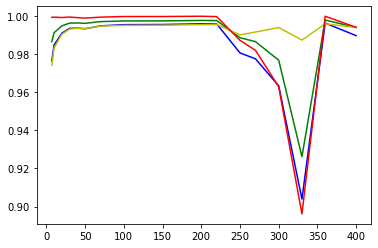

In [227]:
x = [7,10,20,30,40,50,70,100,150,200, 220, 250, 270,300,330, 360,400]
plt.plot(x, model_tree.cv_results_['mean_test_accuracy'],'b')
plt.plot(x, model_tree.cv_results_['mean_test_f1'],'g')
plt.plot(x, model_tree.cv_results_['mean_test_precision'],'y')
plt.plot(x, model_tree.cv_results_['mean_test_recall'],'r')
plt.show()

In [228]:
selected_model = GradientBoostingClassifier(learning_rate=0.5, max_depth=4, max_features='sqrt',n_estimators=360)
selected_model.fit(X_train,loan_train['target'])
y_predicted = selected_model.predict(X_test)
print('Test Accuracy',accuracy_score(y_predicted, loan_test['target']))
print('Test Precision',precision_score(y_predicted, loan_test['target']))
print('Test Recall',recall_score(y_predicted, loan_test['target']))

Test Accuracy 0.9956570467918184
Test Precision 0.9995050730017322
Test Recall 0.9953996549741231


# Comparison with Decision Tree

In [229]:
DT = DecisionTreeClassifier()
DT = DT.fit(X_train,loan_train['target'])
y_predicted = DT.predict(X_test)
print('Test Accuracy',accuracy_score(y_predicted, loan_test['target']))
print('Test Precision',precision_score(y_predicted, loan_test['target']))
print('Test Recall',recall_score(y_predicted, loan_test['target']))

Test Accuracy 0.9913841412160269
Test Precision 0.9942258516868762
Test Recall 0.9956220056170494
